In [1]:
from __future__ import division
%matplotlib inline
import cPickle
import datetime
from dateutil import parser
import itertools
import math
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0, 8.0)
import numpy as np
import os
import pandas as pd
from scipy.integrate import quadrature, romberg, quad, fixed_quad
from scipy.interpolate import interp1d
from scipy.special import legendre
from tqdm import tqdm_notebook

In [209]:
TIME = pd.datetime(2017, 4, 22, 9, 0, 0)
WAVELENGTH = 532

# Load the sunphotometer data

## Load the phasefunction

The data is loaded from the sunphotometer logs. Note that new values are interpolated for TIME and WAVELENGTH. I use the "pchip" interpolation method as it is more conservative.

In [242]:
def dateparse(d, t):
    return pd.datetime.strptime(d+' '+t, '%d:%m:%Y %H:%M:%S')

def parsePhaseFunction(path, usecols):
    """Parse the sunphotometer Phase Function data."""

    df = pd.read_csv(
        path,
        skiprows=3,
        header=0,
        parse_dates=[[0, 1]],
        date_parser=dateparse,
        index_col=0,
        usecols=usecols
    )

    wavelengths = [float(i.split("[")[0]) for i in df.columns]
    df = df.rename(columns=dict(itertools.izip(df.columns, wavelengths)))
    df.index.rename("datetime", inplace=True)
    
    new_row = pd.Series(name=TIME, data=[None]*len(df.columns), index=df.columns)
    df = df.append(new_row)
    df = df.sort_index().interpolate(method="pchip")

    return df, wavelengths

pfn_path = r"../../data/phase_functions/170422_170422_Technion_Haifa_IL.pfn"
df_441, wavelengths = parsePhaseFunction(
    pfn_path,
    usecols=[0, 1]+list(range(3, 86))
)
df_674, wavelengths = parsePhaseFunction(
    pfn_path,
    usecols=[0, 1]+list(range(86, 169))
)
df_871, wavelengths = parsePhaseFunction(
    pfn_path,
    usecols=[0, 1]+list(range(169, 252))
)
df_1020, wavelengths = parsePhaseFunction(
    pfn_path,
    usecols=[0, 1]+list(range(252, 335))
)

In [244]:
series = [pd.Series(d.loc[TIME], name=n) for d, n in zip((df_441, df_674, df_871, df_1020), (441., 674., 871., 1020.))]
df_phf = pd.concat(series, axis=1).T
new_row = pd.Series(name=WAVELENGTH, data=[None]*len(df_phf.columns), index=df_phf.columns)
df_phf = df_phf.append(new_row).sort_index().interpolate(method="pchip")

In [245]:
df_phf.head()

,0.0,1.71,3.93,6.16,8.39,10.63,12.86,15.1,17.33,19.57,...,160.43,162.67,164.9,167.14,169.37,171.61,173.84,176.07,178.29,180.0
441.0,383.893180,186.850574,64.194264,28.736611,16.172713,10.849754,8.173280,6.576591,5.478516,4.667325,...,0.150078,0.153781,0.159405,0.166180,0.174326,0.184434,0.198797,0.219541,0.238092,0.244221
532.0,294.268807,163.532276,64.113358,30.976338,17.573838,11.588148,8.529461,6.704261,5.509897,4.670883,...,0.169100,0.173586,0.179496,0.186924,0.196175,0.208262,0.226584,0.253041,0.275884,0.283162
674.0,195.824128,132.900076,63.693290,33.006799,19.300419,12.645334,9.126265,6.999061,5.639574,4.689648,...,0.186272,0.191291,0.197436,0.205635,0.216531,0.231669,0.255066,0.287585,0.314126,0.322197
871.0,130.716125,101.379566,58.150319,33.582892,20.848179,13.922779,10.041726,7.634965,6.073607,4.983534,...,0.191004,0.195842,0.202006,0.210763,0.223374,0.241949,0.269960,0.306059,0.333153,0.340889
1020.0,101.426135,83.843111,53.213466,32.975240,21.374993,14.596655,10.624687,8.108140,6.440692,5.263151,...,0.190392,0.194852,0.200809,0.209796,0.223514,0.244204,0.274514,0.311375,0.337490,0.344657


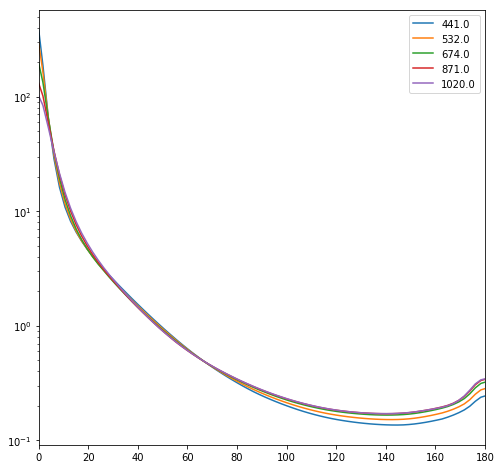

In [261]:
df_phf.T.plot(logy=True)

## Load the Single-Scatter Albedo

In [256]:
def parseSSA(path):
    """Parse the sunphotometer SSA data."""

    df = pd.read_csv(
        path,
        skiprows=3,
        header=0,
        parse_dates=[[0, 1]],
        date_parser=dateparse,
        index_col=0,
        usecols=[0, 1]+list(range(3, 7))
    )

    wavelengths = [float(i[3:-2]) for i in df.columns]
    df = df.rename(columns=dict(itertools.izip(df.columns, wavelengths)))
    df.index.rename("datetime", inplace=True)
    
    new_row = pd.Series(name=TIME, data=[None]*len(df.columns), index=df.columns)
    df = df.append(new_row)
    df = df.sort_index().interpolate(method="pchip")

    return df

ssa_path = r"../../data/phase_functions/170422_170422_Technion_Haifa_IL.ssa"

df_ssa = parseSSA(ssa_path)

### Interpolate by wavelength

In [257]:
new_row = pd.Series(name=WAVELENGTH, data=[None]*len(df_ssa.T.columns), index=df_ssa.T.columns)

df_ssa = df_ssa.T.append(new_row).sort_index().interpolate(method="pchip")

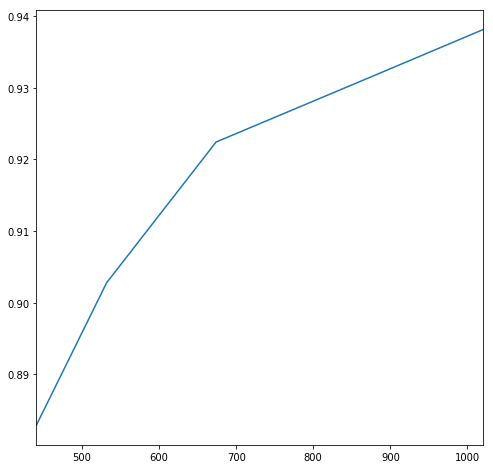

In [260]:
df_ssa.T.loc[TIME].T.plot()

In [273]:
df_ssa.loc[WAVELENGTH][TIME]

0.90278619666356374

# Calculate the Legndre Coefficients

The (intensity) phase function is conventionally normalized as follows

$$\int_0^{2\pi} \int_0^\pi P(\Theta) \sin(\Theta) d\Theta d\phi = 4 \pi$$

Which is equivalent to

$$\int_{-1}^1 P(\cos{\Theta}) d(\cos{\Theta}) = 2$$

Integrating the phase function from the sunphotometer gives:

In [6]:
mu = np.cos(np.radians(wavelengths[::-1]))
phase = df_441.transpose()[[ u'2017-04-22 06:40:30', u'2017-04-22 12:40:33']].mean(axis=1).values[::-1]
np.trapz(phase, mu)

2.0864231255116943

# Calculate the Legendre Coefficients

## Use quadrature integration

In [7]:
COFFES_NUM = 300

In [262]:
mu = np.cos(np.radians(wavelengths[::-1]))
phase = df_phf.loc[WAVELENGTH].values[::-1]

phase_interp = interp1d(mu, phase, kind=3)

def func(x, l, lg):
    return (2*l + 1)/2. * lg(x)*phase_interp(x)

In [263]:
coeffs_quad = []
for l in tqdm_notebook(range(COFFES_NUM)):
    lg = legendre(l)
    coeffs_quad.append(quad(func, -1, 1, args=(l, lg,), limit=1000)[0])
    #coeffs_quad.append(fixed_quad(func, -1, 1, args=(l, lg,), n=10000)[0])

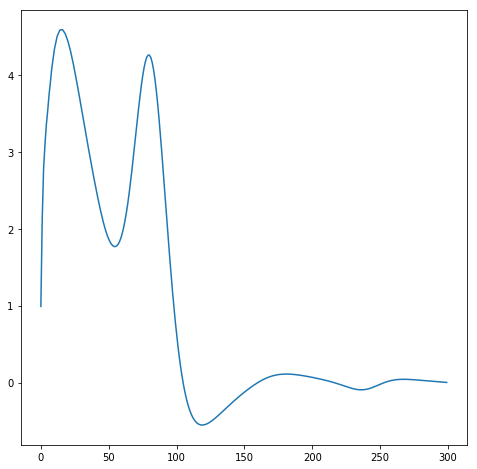

In [264]:
plt.plot(coeffs_quad)

## Reconstruct the Phase function by the Legndre coefficients

In [265]:
mu_new = np.linspace(-1, 1, 300)
phase_gauss = 0
for l, coeff in enumerate(coeffs_quad):
    phase_gauss += legendre(l)(mu_new) * coeff
coeffs_quad_ = coeffs_quad[:]
coeffs_quad_[0] = 1.
phase_gauss_ = 0
for l, coeff in enumerate(coeffs_quad_):
    phase_gauss_ += legendre(l)(mu_new) * coeff

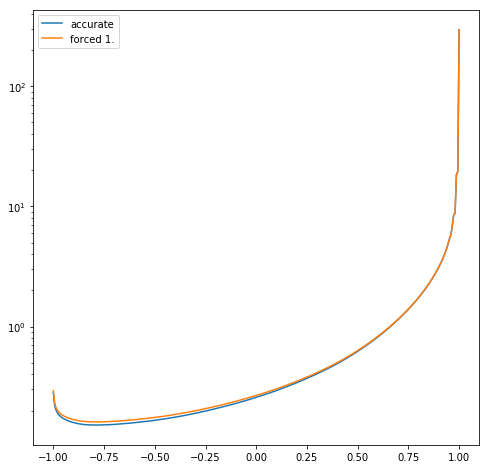

In [266]:
plt.semilogy(mu_new, phase_gauss, label="accurate")
plt.semilogy(mu_new, phase_gauss_, label="forced 1.")
plt.legend()
#plt.xlim(0.96, 1)

### Save the result

In [302]:
header = """! Mie scattering table vs. effective radius (LWC=1 g/m^3)
  0.{}    0.{}    0.000  wavelength range and averaging step (micron)
   2    1.450    1.450  number       starting       ending REAL refractive index
   2    0.000    0.000  number       starting       ending IMAGINARY refractive index
   2    0.100    0.100  number       starting       ending effective radius
   2    0.500    0.500  number       starting       ending effective variance
 """.format(WAVELENGTH, WAVELENGTH)
line_template = " 1.450 -.000     1.000    %f   0.5000   0.1000     %d  Phase function: Re{m}  Im{m}   Ext  Alb  Veff  Reff  Nleg\n"

In [304]:
with open("aerosol{}dredvedm.scat".format(WAVELENGTH), "w") as f:
    f.write(header)
    for i in range(700):
        f.write(line_template % (df_ssa.loc[WAVELENGTH][TIME], len(coeffs_quad_)-1))
        f.write("\t".join(['']+[str(c) for c in coeffs_quad_]))
        f.write("\n")

# Playground

In [27]:
l = 0
lg = legendre(l)
print("Fixed:", fixed_quad(func, -1, 1, args=(l, lg,), n=10000))
print("Quadrature:", quadrature(func, -1, 1, args=(l, lg,), maxiter=1000))
print("Quad:", quad(func, -1, 1, args=(l, lg,), limit=20000))

('Fixed:', (0.99223558782933319, None))
('Quadrature:', (0.99222757511444437, 9.9960529853504454e-09))
('Quad:', (0.9922355873571473, 1.4491873774508622e-08))


In [6]:
a = "1.00000    2.17461    3.11673    3.21224    3.69729    3.71195    3.97622    4.06767    4.13853    4.23242    4.16973    4.21562    4.09315    4.06826    3.93073    3.84457    3.71150    3.58483    3.45925    3.31342    3.19372    3.04401    2.92860    2.78425    2.67307    2.53813    2.43184    2.30690    2.20596    2.09139    1.99636    1.89136    1.80508    1.71015    1.63210    1.54267    1.47150    1.39360    1.33225    1.26170    1.20735    1.14139    1.09004    1.02917    0.98476    0.93167    0.89362    0.84361    0.80635    0.76328    0.73347    0.69305    0.66612    0.62870    0.60402    0.57074    0.54977    0.51867    0.49850    0.47256    0.45384    0.43085    0.41363    0.39225    0.37683    0.35864    0.34504    0.32811    0.31522    0.29960    0.28856    0.27429    0.26446    0.25114    0.24254    0.23015    0.22191    0.21111    0.20400    0.19386    0.18721    0.17826    0.17242    0.16397    0.15861    0.15060    0.14596    0.13876    0.13458    0.12778    0.12377    0.11788    0.11424    0.10896    0.10545    0.10064    0.09738    0.09301    0.09019    0.08611    0.08350    0.07976    0.07742    0.07392    0.07173    0.06856    0.06654    0.06355    0.06172    0.05900    0.05733    0.05477    0.05326    0.05093    0.04955    0.04734    0.04605    0.04405    0.04288    0.04103    0.03990    0.03817    0.03715    0.03559    0.03470    0.03321    0.03237    0.03098    0.03021    0.02890    0.02816    0.02700    0.02633    0.02525    0.02462    0.02362    0.02303    0.02211    0.02154    0.02071    0.02017    0.01941    0.01891    0.01819    0.01772    0.01707    0.01664    0.01603    0.01563    0.01505    0.01469    0.01413    0.01380    0.01327    0.01296    0.01246    0.01216    0.01171    0.01143    0.01102    0.01076    0.01038    0.01015    0.00979    0.00956    0.00921    0.00900    0.00868    0.00848    0.00819    0.00800    0.00773    0.00755    0.00729    0.00713    0.00689    0.00674    0.00651    0.00636    0.00614    0.00601    0.00580    0.00568    0.00548    0.00537    0.00519    0.00508    0.00490    0.00479    0.00463    0.00454    0.00438    0.00430    0.00415    0.00407    0.00393    0.00385    0.00372    0.00365    0.00353    0.00346      0.00335    0.00328    0.00318    0.00311    0.00301    0.00295    0.00286    0.00280    0.00271    0.00266    0.00257    0.00252    0.00244    0.00239    0.00232    0.00227    0.00221    0.00216    0.00210    0.00205    0.00199    0.00195    0.00189    0.00186    0.00180    0.00177    0.00171    0.00168    0.00163    0.00160    0.00155    0.00152    0.00148    0.00145    0.00140    0.00138    0.00134    0.00131    0.00127    0.00125    0.00121    0.00119    0.00116    0.00114    0.00110    0.00108    0.00105    0.00103    0.00100    0.00099    0.00096    0.00094    0.00091    0.00090    0.00087    0.00086    0.00083    0.00082    0.00080    0.00078    0.00076    0.00075    0.00073    0.00072    0.00070    0.00068    0.00067    0.00065    0.00064    0.00063    0.00061    0.00060    0.00058    0.00057    0.00056    0.00055    0.00053    0.00052    0.00051    0.00050    0.00049    0.00048    0.00046    0.00046    0.00044    0.00044    0.00043    0.00042    0.00041    0.00040    0.00039    0.00038    0.00037    0.00037    0.00036    0.00035    0.00034    0.00034    0.00033    0.00032    0.00031    0.00031    0.00030    0.00030    0.00029    0.00029    0.00028    0.00027    0.00027    0.00026    0.00026    0.00025    0.00025    0.00024    0.00024    0.00023    0.00023    0.00022    0.00022    0.00021    0.00021    0.00021    0.00020    0.00020    0.00019    0.00019    0.00019    0.00018    0.00018    0.00018    0.00017    0.00017    0.00016    0.00016    0.00016    0.00016    0.00015    0.00015    0.00015    0.00014    0.00014    0.00014    0.00013    0.00013    0.00013    0.00013    0.00012    0.00012    0.00012    0.00012    0.00011    0.00011    0.00011    0.00011    0.00011    0.00010    0.00010    0.00010    0.00010    0.00010    0.00009    0.00009    0.00009    0.00009    0.00009    0.00009    0.00008    0.00008    0.00008    0.00008    0.00008    0.00008    0.00007    0.00007    0.00007    0.00007    0.00007    0.00007    0.00007    0.00007    0.00006    0.00006    0.00006    0.00006    0.00006    0.00006    0.00006    0.00006    0.00006    0.00005    0.00005    0.00005    0.00005    0.00005    0.00005    0.00005    0.00005    0.00005    0.00005    0.00005      0.00004    0.00004    0.00004    0.00004    0.00004    0.00004    0.00004    0.00004    0.00004    0.00004    0.00004    0.00004    0.00004    0.00004    0.00003    0.00003    0.00003    0.00003    0.00003    0.00003    0.00003    0.00003    0.00003    0.00003    0.00003    0.00003    0.00003    0.00003    0.00003    0.00003    0.00003    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00002    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001    0.00001"

In [9]:
coeffs_quad = np.array([float(i) for i in a.split()])

In [10]:
coeffs_quad.dtype

dtype('float64')

In [11]:
mu_new = np.linspace(-1, 1, 300)
phase_gauss = 0
for l, coeff in enumerate(coeffs_quad):
    phase_gauss += legendre(l)(mu_new) * coeff

C:\Anaconda2\lib\site-packages\scipy\special\orthogonal.py:145: RuntimeWarning: invalid value encountered in multiply
  self.__dict__['coeffs'] *= kn
C:\Anaconda2\lib\site-packages\scipy\special\orthogonal.py:1593: RuntimeWarning: overflow encountered in double_scalars
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n
C:\Anaconda2\lib\site-packages\scipy\special\orthogonal.py:1593: RuntimeWarning: invalid value encountered in double_scalars
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n


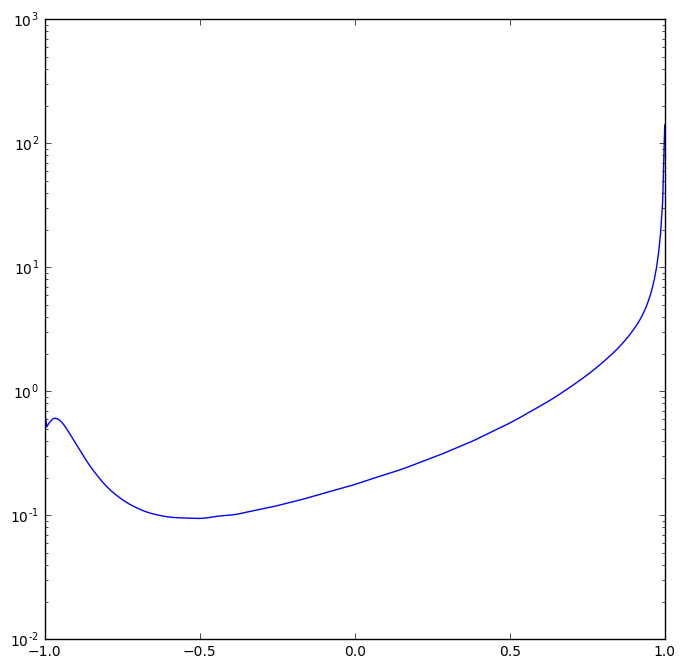

In [12]:
plt.semilogy(mu_new, phase_gauss)
#plt.semilogy(mu, phase, '+')

## Test with Henyey-Greenstein function

p(µ) = 1
2
1 − g
2
[1 + g
2 − 2g µ ]
3/2


In [69]:
COFFES_NUM = 100

In [70]:
def hg(mu, g):
    ph = (1/2)*(1-g**2)/(1+g**2-2*g*mu)**(1.5)
    return ph

def func(mu, l, g):
    return (2*l + 1)/2. * legendre(l)(mu)*hg(mu, g)

G=0.7
coeffs_hg_quad = []
for l in tqdm_notebook(range(COFFES_NUM)):
    coeffs_hg_quad.append(quadrature(func, -1, 1, args=(l, G), maxiter=200, )[0])

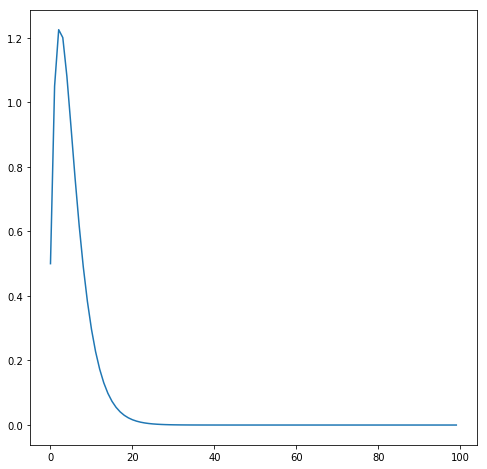

In [71]:
plt.plot(coeffs_hg_quad)

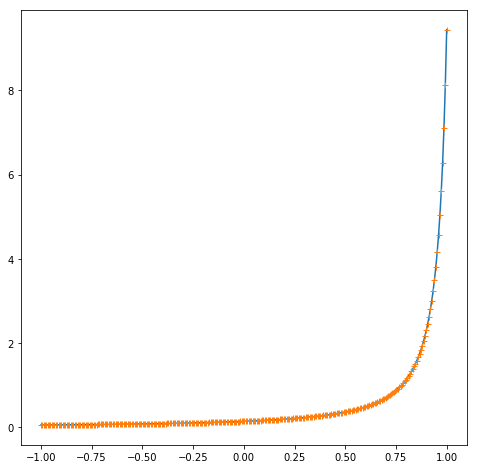

In [72]:
mu_new = np.linspace(-1, 1, 300)
phase_hg = 0
for l, coeff in enumerate(coeffs_hg_quad):
    phase_hg += legendre(l)(mu_new) * coeff
plt.plot(mu_new, phase_hg)
real_hg = [hg(m, G) for m in mu_new]
plt.plot(mu_new, real_hg, '+')

## Test with a single coefficient function

In [65]:
COFFES_NUM = 100
LG = 1

In [66]:
def lg(mu, l):
    return legendre(l)(mu)

def func(mu, l, l2):
    return (2*l + 1)/2. * legendre(l)(mu)*lg(mu, l2)

coeffs_lg_quad = []
for l in tqdm_notebook(range(COFFES_NUM)):
    coeffs_lg_quad.append(quadrature(func, -1, 1, args=(l, LG), maxiter=200, )[0])

(0, 10)

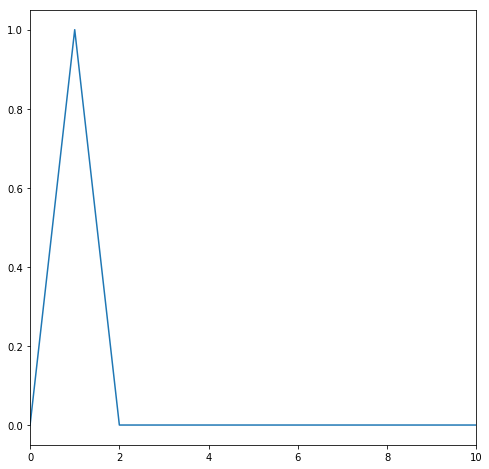

In [67]:
plt.plot(coeffs_lg_quad)
plt.xlim(0, 10)

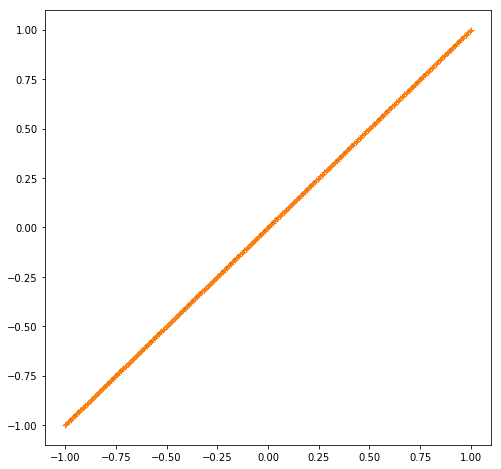

In [68]:
mu_new = np.linspace(-1, 1, 300)
phase_lg = 0
for l, coeff in enumerate(coeffs_lg_quad):
    phase_lg += legendre(l)(mu_new) * coeff
plt.plot(mu_new, phase_lg)
real_lg = [lg(m, LG) for m in mu_new]
plt.plot(mu_new, real_lg, '+')

## Use trapezoidale integration

Note that at coefficient 86 we get some warning. P_86 has occilations at about the sampleing frequency of the data (180 degrees / 2 degrees between samples). See the graph below.

In [6]:
coeffs_trapz = []
for l in range(86):
    coeffs_trapz.append((2*l + 1)/2. * np.trapz(legendre(l)(mu)*phase, mu))

In [7]:
mu_new = np.linspace(-1, 1, 300)
phase_trapz = legendre(0)(mu_new) * coeffs_trapz[0]
for l, coeff in enumerate(coeffs_trapz[1:]):
    phase_trapz += legendre(l)(mu_new) * coeff

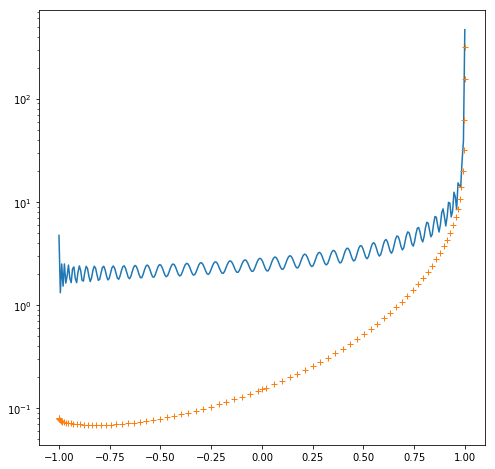

In [8]:
plt.semilogy(mu_new, phase_trapz)
plt.semilogy(mu, phase, '+')

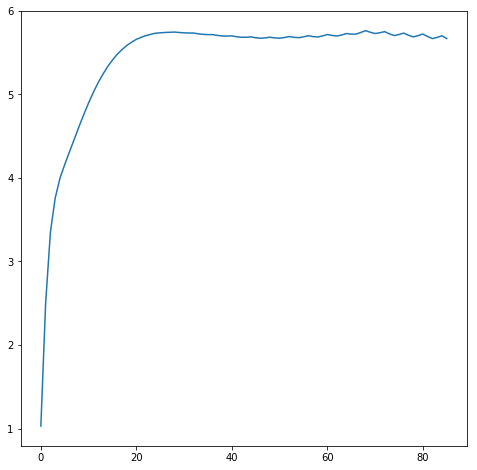

In [9]:
plt.plot(coeffs_trapz)

In [10]:
coeffs_trapz[0]

1.0301850781945259

## Use romberg integration

In [11]:
COFFES_NUM = 300

In [15]:
phase_interp = interp1d(mu, phase)

def func(x, l):
    return (2*l + 1)/2. * legendre(l)(x)*phase_interp(x)

coeffs_romberg = []
for l in tqdm_notebook(range(COFFES_NUM)):
    coeffs_romberg.append(romberg(func, -1, 1, args=(l,), vec_func=True))

C:\ProgramData\Anaconda2\lib\site-packages\scipy\integrate\quadrature.py:706: AccuracyWarning: divmax (10) exceeded. Latest difference = 2.359110e+01
  AccuracyWarning)
C:\ProgramData\Anaconda2\lib\site-packages\scipy\special\orthogonal.py:145: RuntimeWarning: invalid value encountered in multiply
  self.__dict__['coeffs'] *= kn
C:\ProgramData\Anaconda2\lib\site-packages\scipy\integrate\quadrature.py:706: AccuracyWarning: divmax (10) exceeded. Latest difference = 2.319771e+01
  AccuracyWarning)
C:\ProgramData\Anaconda2\lib\site-packages\scipy\integrate\quadrature.py:706: AccuracyWarning: divmax (10) exceeded. Latest difference = 2.280286e+01
  AccuracyWarning)
C:\ProgramData\Anaconda2\lib\site-packages\scipy\integrate\quadrature.py:706: AccuracyWarning: divmax (10) exceeded. Latest difference = 2.227783e+01
  AccuracyWarning)
C:\ProgramData\Anaconda2\lib\site-packages\scipy\integrate\quadrature.py:706: AccuracyWarning: divmax (10) exceeded. Latest difference = 2.175210e+01
  AccuracyWa

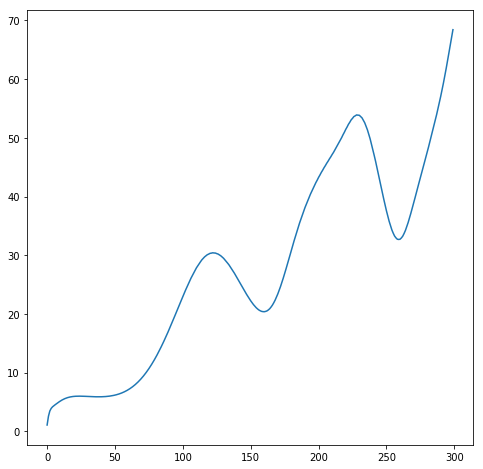

In [16]:
plt.plot(coeffs_romberg)

In [17]:
mu_new = np.linspace(-1, 1, 300)
phase_gauss = legendre(0)(mu_new) * coeffs_romberg[0]
for l, coeff in enumerate(coeffs_romberg[1:]):
    phase_gauss += legendre(l)(mu_new) * coeff

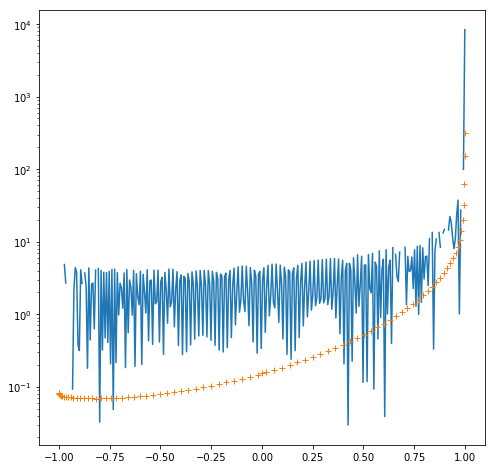

In [18]:
plt.semilogy(mu_new, phase_gauss)
plt.semilogy(mu, phase, '+')